# Improving *in vitro* using *in vivo* data

The focus of this notebook is to start a fresh outline the whole journey as clearly as can be. Only the relevant sections to the story in my thesis will make it to this notebook from the other one. 

The following sections should be copvered:
* A quick versioning and source of the algorithms used
* Source of data
* The Python requirements
* The support, separate modules
* The ireations as folows:


Some of the main requirements to do this are:
* The modified Perl code used to incorporate in vivo information
* The helper scripts used for counting and data conversion
* The kmer counts previously generated:
 - Counts in human genome
 - count in Dnase data
 - frequency difference of that count
* Then we can directly generate the motifs and test how they are performing


With the machine elarning angle to the project established, the next stage is to get this working. Improve on it by using a better scoring function, and also do a bit of comparisons. 

Some action points related top this chapter:
* Transform debruijn with dn-hg
* A background noise correction
    * Re-rank with k-mer frequency count difference (hg-dn, considered as noise)
    * Jiangs approach

### Requirements:
1. The original Seed and Wobble algorithms from http://the_brain.bwh.harvard.edu/PBMAnalysisSuite/index.html
2. A modified version of the algorithm to take in k-mer frequency counts from http://www.bioinf.ict.ru.ac.za/counts_SnW
3. An executable motif algorithm baded on Gibbs sampling from "http://thebrain.bwh.harvard.edu/hierarchicalANOVA/"

In [4]:
import os
import glob

import pandas as pd
import seaborn as sns

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Import MARSTools for evaluations

In [5]:
cd /home/kipkurui/MARS/

/home/kipkurui/MARS


In [6]:
from MARSTools import Assess_by_score as score

## Set the base directory and figure path

In [26]:
BASE_DIR = "/home/kipkurui/Project/PBM_DNase"

In [8]:
figure_path = "/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter6/Figs"

### Get a list of TFs affected by Sticky k-mers

The Sticky k-mers Identified by Jiang et al and downloadable from: are used . 

In [9]:
pbm_chip = []
pbmchip2name = {}
with open('/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/Data/Pbm_Chip_details.txt') as pbmnchip:
    for line in pbmnchip:
        if line.startswith('Tf_id'):
            continue
        else:
            pbm_chip.append(line.split()[0])
            pbmchip2name[line.split()[0]] = line.split()[1]

#revers the dictornary
name2pbmchip = {v: k for k, v in pbmchip2name.items()}

In [11]:
sticky_tfs = pd.read_table("/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/anova_example/input/names.txt", header=None)
tf_list = []
for tf in sticky_tfs[0]:
    chip_list = glob.glob("/home/kipkurui/Project/MARS/Data/ChIP-seq/Derived/Posneg/%s/*" % tf.capitalize())
    if len(chip_list) > 0:
        tf_list.append(tf)

## Temp, they should be imported from MARS

In [8]:
revcompl = lambda x: ''.join([{'A':'T','C':'G','G':'C','T':'A'}[B] for B in x][::-1])
def mkdir_p(path):
    import os
    import errno

    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def get_unique(tf):
    import glob
    lests = glob.glob("/home/kipkurui/Project/MARS/Data/PBM/%s/*" % tf.capitalize())
    new = []
    for i in lests:
        main = i.split("_v")[0]
        if main in new:
            continue
        else:
            new.append(main)
    return new

def find_kmers(string, kmer_size):
    kmers = []
    for i in range(0, len(string)-kmer_size+1):
        kmers.append(string[i:i+kmer_size])
    return kmers

def get_kmer_dict(kmerscore, kmer_name):
    """
    Try and make this generalized by checking if the first line has header or not. 
    
    Also, check the number of columns and determine which one contains the E-scores
    """

    test = pd.read_table(kmerscore, index_col="8-mer.1", usecols=["8-mer", "E-score"])

    scoredict  = test.to_dict()["E-score"]
    # with open(kmerscore) as kmers:
    #     print kmerscore
    #     for line in kmers:
    #         ke, rems, val = line.split("\t")
    #
    #         scoredict[ke] = val
    return scoredict, kmer_name

def get_kmer_dict_rev(kmerscore, kmer_name):
    test = pd.read_table(kmerscore, index_col="8-mer", usecols=["8-mer", "E-score"])
    test.fillna(0, inplace=True)
    test2 = pd.read_table(kmerscore, index_col="8-mer.1", usecols=["8-mer.1", "E-score"])
    test2.index.name = "8-mer"
    test2.fillna(0, inplace=True)
    combined = test.append(test2)
    combined_dict = combined.to_dict()["E-score"]

    return combined_dict, kmer_name

def energy_score_kmer(seq,kmerdict,revcompl):
    k_mers=find_kmers(seq,8)
    tot_score = 0
    for kmer in k_mers:
        if kmer in kmerdict:
            score=float(kmerdict[kmer])
        else:
            kmer2=revcompl(kmer)
            score=float(kmerdict[kmer2])
        tot_score+=score
    return tot_score

In [ ]:
scripts_path = "/home/kipkurui/Project/PBM_DNase/Scripts"
!cd {scripts_path}

## 1. Transform deBruijn sequences by scoring

The idea behind this approach is to use the dn-hg frequency counts as a measure of k-mer preference to be found in an open chromatin site. The human genome DNase sites frequency difference is used to transform eh deBruijn sequences. 



In [ ]:
def run_assess(tf, mot_path="%s/Results/PBM_Reranked" % BASE_DIR):
    user_motif = "%s/%s/%s.meme" % (mot_path, tf.capitalize(), tf.capitalize())
    chip_list = glob.glob("/home/kipkurui/Project/MARS/Data/ChIP-seq/Derived/Posneg/%s/*" % tf.capitalize())
    score.run_all(tf.lower(), 'energyscore', user_motif, chip_list, "%s/%s" % (mot_path, tf.capitalize())) 

In [7]:
def combine_meme(tf, path="%s/Results/PBM_Reranked" % BASE_DIR):
    """
    Within a directory, after a seed and wobble run, 
    combine all meme output into a single file. 
    
    """
    meme_out = "%s/%s/%s.meme" % (path,tf.capitalize(), tf.capitalize())
    if os.path.isfile(meme_out):
        os.remove(meme_out)
    meme_motifs = glob.glob("%s/%s/*meme" % (path,tf.capitalize()))
    
    mot = meme_motifs[0]
    !head -9 {mot} >{meme_out}
    for mot in meme_motifs:
        tots = !wc -l {mot}
        !tail -{int(tots[0].split()[0]) -8} {mot} >>{meme_out}
        

def run_SnW(tf, mot="%s/Data/PBM_Reranked" % BASE_DIR):
    """
    
    """
    out_dir = "%s/%s" % ("%s/Data/PBM_Reranked2" % BASE_DIR,tf.capitalize())
    res_dir = "%s/%s" % (mot,tf.capitalize())
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        probe_n =probe.split("/")[-1]
        v1 = "%s/%s_v%i_reranked_Hg_dn-less.txt" % (out_dir, probe_n,1)
        v2 = "%s/%s_v%i_reranked_Hg_dn-less.txt" % (out_dir, probe_n,2)
        !perl {scripts_path}/seed_and_wobble_twoarray.pl {v1} {v2} 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt {res_dir}/{probe_n}_reranked
        !python {scripts_path}/wobble2meme.py {res_dir}/{probe_n}_reranked_8mers_pwm_combined.txt {res_dir}/{probe_n}_reranked.uniprobe {res_dir}/{probe_n}_reranked.meme {probe_n}_reranked
    combine_meme(tf,mot)
    run_assess(tf, mot)
    

    
def run_SnW_normal(tf):
    """
    Performs a normal Seed and wobble run
    """
    script = "/home/kipkurui/Project/PBM_DNase/Scripts/"
    out_dir = "/home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked/%s" % tf.capitalize()
    res_dir = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Normal/%s" % tf.capitalize()
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        probe_n =probe.split("/")[-1]
        v1 = "%s_v%i_deBruijn.txt" % (probe,1)
        v2 = "%s_v%i_deBruijn.txt" % (probe,2)
        !perl {script}seed_and_wobble_twoarray.pl {v1} {v2} 8 {script}patterns_8of10.txt {script}patterns_4x44k_all_8mer.txt {res_dir}/{probe_n}_deBruijn
        !python {script}wobble2meme.py {res_dir}/{probe_n}_deBruijn_8mers_pwm_combined.txt {res_dir}/{probe_n}_deBruijn.uniprobe {res_dir}/{probe_n}_deBruijn.meme {probe_n}_deBruijn
    #combine_meme(tf, path="%s/Results/PBM_Normal" % BASE_DIR)
    #run_assess(tf, mot_path="%s/Results/PBM_Normal" % BASE_DIR)

In [8]:
def run_SnW_counts(tf, scalled):
    """
    Uses the DN-HG frequency counts transformed using minimum absolute from scikit learn.  
    """
    out_dir = "/home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked/%s" % tf.capitalize()
    res_dir = "/home/kipkurui/Project/PBM_DNase/Results/PBM_PWM/%s" % tf.capitalize()
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        print probe
        probe_n =probe.split("/")[-1]
        v1 = "%s_v%i_deBruijn.txt" % (probe,1)
        v2 = "%s_v%i_deBruijn.txt" % (probe,2)
        !perl counts_seed_and_wobble_twoarray.pl {v1} {v2} 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt {scalled} {res_dir}/{probe_n}_Counts
        !python wobble2meme.py {res_dir}/{probe_n}_deBruijn_8mers_pwm_combined.txt {res_dir}/{probe_n}_deBruijn.uniprobe {res_dir}/{probe_n}_deBruijn.meme {probe_n}_deBruijn
    combine_meme(tf)
    run_assess(tf)

In [9]:
def run_rerank(tf):
    """
    Takes as input, TF name and per
    """
    out_dir = "/home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked/%s" % tf.capitalize()
    res_dir = "%s/Results/PBM_PWM/%s" % (BASE_DIR,tf.capitalize())
    script = "/home/kipkurui/Project/PBM_DNase/Scripts"
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        print probe
        probe_n =probe.split("/")[-1]
        v1 = "%s_v%i_deBruijn.txt" % (probe,1)
        v2 = "%s_v%i_deBruijn.txt" % (probe,2)
        scalled ="/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise_minabs.txt"
        !perl {scripts_path}counts_seed_and_wobble_twoarray.pl {v1} {v2} 8 {scripts_path}/patterns_8of10.txt patterns_4x44k_all_8mer.txt {scalled} {res_dir}/{probe_n}_Counts

        !perl {scripts_path}/rerank.pl {v1} {res_dir}/{probe_n}_Counts_8mers_pwm_combined.txt {res_dir}/{probe_n}_v1_reranked.txt
        !perl {scripts_path}/rerank.pl {v2} {res_dir}/{probe_n}_Counts_8mers_pwm_combined.txt {res_dir}/{probe_n}_v2_reranked.txt
        
        !perl {scripts_path}/seed_and_wobble_twoarray.pl {v1} {v2} 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt {probe_n}
        
        !python {scripts_path}/wobble2meme.py {res_dir}/{probe_n}_Counts_reranked_8mers_pwm_combined.txt {res_dir}/{probe_n}_Counts_reranked.uniprobe {res_dir}/{probe_n}_Counts_reranked.meme {probe_n}_Counts_reranked
    combine_meme(tf, "%s/Results/PBM_PWM" % BASE_DIR)
    run_assess(tf, "%s/Results/PBM_PWM" % BASE_DIR)

In [18]:
remain_list = [
 'Rxra',
 'Mafk',
 'Sp1']

In [20]:
for tf in tf_list:
    print tf
    #run_SnW_normal(tf)
    #combine_meme(tf, path="%s/Results/PBM_Normal" % BASE_DIR)
    run_assess(tf, mot_path="%s/Results/PBM_Normal" % BASE_DIR)

Foxa2
Gata3


IOError: [Errno 2] No such file or directory: '/home/kipkurui/Project/PBM_DNase/Results/PBM_Normal/Gata3/Gata3.meme'

In [ ]:
tf

In [5]:
cd {scripts_path}

/home/kipkurui/Project/PBM_DNase/Scripts


In [11]:
!cd /home/kipkurui/MARS/
from MARSTools import Assess_by_score as score

In [10]:
cd /home/kipkurui/MARS/

/home/kipkurui/MARS


### b) Re-ranking intensity scores

This option uses the preferred k-mer information to score sequences and use them to re-weigh the instensity scores. This is then directly followed by a normal seed and wobble run. Besides, at this stage, any algorithm can be used. The main area that actually need proper optimisation is the best way of re-weighing the scores. 

In [7]:
def transform_deBruijn(tf, kmerscore):
    """
    Given kmer frequency counts, use the information to tranform the deBruijn 
    intensity scores in a way that would reflect in vivo binding behaviour. 
    TODO: 
    """
    scoredict = get_kmer_dict_rev(kmerscore,"test")[0]
    out_dir = "/home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked2/%s" % tf.capitalize()
    mkdir_p(out_dir)
    for probe in get_unique(tf):
        for i in range(1,3):
            debru = pd.read_table("%s_v%i_deBruijn.txt" % (probe,i), header=None)
            scored = debru[1].apply(lambda seq: energy_score_kmer(seq[:36],scoredict,revcompl))
            normalized = scored/scored.max()
            #print normalized
            test = pd.DataFrame()
            test = test.append(debru[0]*normalized, ignore_index=True)
            finall = test.append(debru[1]).T
            finall.sort_values(by=0, ascending=False, inplace=True)
            probe_n =probe.split("/")[-1]
            finall.to_csv("%s/%s_v%i_reranked_Hg_dn-less.txt" % (out_dir, probe_n,i), sep="\t", index=None, index_label=None, header=None)

In [8]:
kmer_score = "/home/kipkurui/Project/Data/Clean/dn_hg_backround_noise_mean_std_maxnormalized_positive.txt"
tf = "Egr1"
#test = pd.read_table(kmer_score, index_col="8-mer.1", usecols=["8-mer", "E-score"])
transform_deBruijn(tf, kmer_score)

In [9]:
pwd

u'/home/kipkurui/Project/MARS'

In [66]:
debru = pd.read_table("%s_v%i_deBruijn.txt" % (probe,i), header=None)

NameError: name 'probe' is not defined

In [10]:
cd {scripts_path}

/home/kipkurui/Project/PBM_DNase/Scripts


In [58]:
tf = "Egr1"

In [11]:
run_SnW(tf,"%s/Results/PBM_Reranked2" % BASE_DIR)

Currently on /home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked2/Egr1/Egr1_2580.1_v1_reranked_Hg_dn-less.txt, spaced seed: 11111111
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
Currently on /home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked2/Egr1/Egr1_2580.1_v2_reranked_Hg_dn-less.txt, spaced seed: 11111111
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
Currently on /home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked2/Egr1/Egr1_2580.1_v1_reranked_Hg_dn-less.txt, spaced seed: 1.1111111
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


ImportError: No module named MARS_Suite

In [14]:
run_assess(tf)

In [97]:
for tf in tf_list:
    transform_deBruijn(tf, kmer_score)
    run_SnW(tf,"%s/Results/PBM_Reranked2" % BASE_DIR)

Currently on /home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked2/Foxa2/Foxa2_2830.2_v1_reranked_Hg_dn-less.txt, spaced seed: 11111111
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
Currently on /home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked2/Foxa2/Foxa2_2830.2_v2_reranked_Hg_dn-less.txt, spaced seed: 11111111
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
Currently on /home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked2/Foxa2/Foxa2_2830.2_v1_reranked_Hg_dn-less.txt, spaced seed: 1.1111111
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [5]:
tf_list

['Foxa2',
 'Gata3',
 'Max',
 'Tcf3',
 'Tcf7l2',
 'Irf3',
 'Irf4',
 'Hnf4a',
 'Nr2f2',
 'Rxra',
 'Egr1',
 'Sp4']

## 2. Using the background correction

This approach uses a modified background correction algorithm by Jiang2013 

In [ ]:
tau_file ="/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise3.txt"
tau_2 = pd.read_table(tau_file, header=None)
tau_new = tau_2 * 0.151863
tau_new.to_csv("/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise_std.txt", index=False, header=False)

In [15]:
def background_correction(kmer_scores, tau_file, res_dir, out_prefix = "corrected"):
    #kmer_score = pd.read_table(kmer_scores)
    kmer_score = pd.read_table(kmer_scores, header=None,usecols=[0,1,3])
    kmer_score.columns = [["8-mer.1", "8-mer", "E-score"]]
    #kmer_score.index.name = "8-mer"
    tau = pd.read_table(tau_file, header=None)
    x = kmer_score["E-score"]
    suffix = "contig8mers.txt"
    s=0.151863
    m=-0.0196628
    
    c = tau*s
    y = x-c[0]
    corrected_kmers = kmer_score.copy()
    corrected_kmers["E-score"] = y
    #corrected_kmers.T.append(y, ignore_index=True).T
    probe_n = kmer_scores.split("/")[-1].split("_contig8mers")[0]
    
    kmer_scores = "%s/%s" % (res_dir,probe.split("/")[-1])
    
    kmer_score.to_csv(kmer_scores.replace("txt", "observed"), sep="\t", header=True, index=False)
    corrected_kmers.to_csv(kmer_scores.replace("txt", out_prefix), sep="\t", header=True, index=False)
    
    corrected_kmers.sort_values(by="E-score", ascending=False, inplace=True)
    
    corrected_kmers[corrected_kmers["E-score"] >0.35]["8-mer"].to_csv(
        kmer_scores.replace(suffix, "%s_kmers.seq" % out_prefix), sep="\t", header=False, index=False)
    
    kmer_score.sort_values(by="E-score", ascending=False, inplace=True)
    
    
    kmer_score[kmer_score["E-score"] >0.35]["8-mer"].to_csv(kmer_scores.replace(
            suffix,"observed_kmers.seq"), sep="\t", header=False, index=False)
    
    !/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/pbm.motif -i {kmer_scores.replace(suffix,"observed_kmers.seq")}
    
    
    !/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/pbm.motif -i {kmer_scores.replace(suffix,"%s_kmers.seq" % out_prefix)}
    
    gibbs2meme(probe_n+"_"+out_prefix, kmer_scores.replace(suffix,"%s_kmers.seq.pwm" % out_prefix))
    
    gibbs2meme(probe_n+"_observed", kmer_scores.replace(suffix,"observed_kmers.seq.pwm"))

u'/home/kipkurui/MARS'

In [24]:
for tf in combined_list:#[combined_list.index('Gata3'):]: #"Egr1  Esrra  Gata3  Hnf4a  Mafk  Max  Myb  Tcf3".split():
    print tf
    res_dir = "%s/%s" % (pbm_reranked,tf.capitalize())
    mkdir_p(res_dir)
    for probe in get_contigmers(tf):
        #probe_n =probe.split("/")[-1]
        kmer_scores = probe
        kmer_scores = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/%s_8mers_combined.txt" % (tf,probe_n)
        
        tau_file = "/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/background_example/estimated_noise.txt"
        background_correction(kmer_scores, tau_file, res_dir, "sticky")
            
        tau_file ="/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise_minabs.txt"
        background_correction(kmer_scores, tau_file, res_dir, "minabs")
        
        tau_file ="/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise_std.txt"
        background_correction(kmer_scores, tau_file, res_dir, "scaled")
        
#         tau_file ="/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise_minmax.txt"
#         background_correction(kmer_scores, tau_file, res_dir, "minmax")
        
#         tau_file = "/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/background_example/reweighed.txt"
#         background_correction(kmer_scores, tau_file, res_dir, "corrected")
        
    combine_meme(tf)
    run_assess(tf)
    run_assess_kmer(tf)

Tcf3


NameError: name 'mkdir_p' is not defined

In [12]:
combined_list = ['Tcf3',
 'Hnf4a',
 'Foxa2',
 'Irf3',
 'Tbp',
 'Irf4',
 'Ap2',
 'Max',
 'Sp4',
 'Jund',
 'Nr2f2',
 'Gata3',
 'Arid3a',
 'Srf',
 'Tcf7l2',
 'Gabp',
 'Egr1',
 'Rxra',
 'Mafk',
 'Sp1']

In [17]:
sns.set(style="white", context="paper")

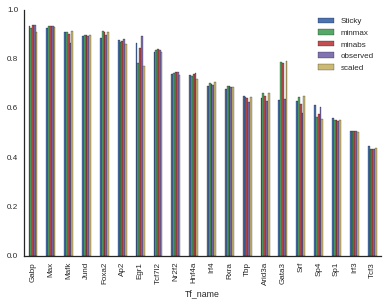

In [19]:
plot_df = pd.DataFrame(columns=["Tf_name", "Sticky", "minmax","minabs", "observed","scaled"])
for tf in combined_list:
    tfs = name2pbmchip[tf]
    #f1000 = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/Kibet-F1000Research/ChIP_seq/Results"
    #f1000 = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/ChIP-seq/Results"
    #test = pd.read_table("%s/%s/%s.energy" % (f1000, tfs,tfs), index_col="Motif")
    energy = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/%s.max_kmer" % (tf.capitalize(), tf.lower())
    #new_test = test.append(pd.read_table(energy, index_col="Motif"))
    new_test = pd.read_table(energy, index_col="Motif")
    new_test.sort_values("AUC", ascending=False, inplace=True)
    # Use this to add each to a specific column fro plotting purpose
    #print tf
    sticky = new_test[new_test.index.str.contains("sticky")]["AUC"].mean()
    minmax = new_test[new_test.index.str.contains("minmax")]["AUC"].mean()
    minabs = new_test[new_test.index.str.contains("minabs")]["AUC"].mean()
    observed = new_test[new_test.index.str.contains("observed")]["AUC"].mean()
    scaled = new_test[new_test.index.str.contains("scaled")]["AUC"].mean()
    
    df2 = pd.DataFrame([[tf, sticky,minmax,minabs,observed,scaled]], columns=["Tf_name","Sticky", "minmax","minabs", "observed","scaled"])
    plot_df = plot_df.append(df2)
    
    #print new_test
plot_df.set_index("Tf_name", inplace=True)
plot_df.sort_values(by="Sticky", ascending=False, inplace=True)
plot_df.plot(kind="bar")
sns.despine()

In [20]:
plot_df.describe()

,Sticky,minmax,minabs,observed,scaled
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.734125,0.738887,0.740363,0.730662,0.735838
std,0.149731,0.150531,0.153358,0.155533,0.149232
min,0.446000,0.437000,0.435000,0.434000,0.438000
25%,0.633625,0.648750,0.636500,0.623500,0.651250
50%,0.716500,0.738500,0.745500,0.720500,0.729500
75%,0.881875,0.877313,0.882437,0.885062,0.872687
max,0.935000,0.935000,0.940000,0.940000,0.934500


In [23]:
pwd

u'/home/kipkurui/MARS'

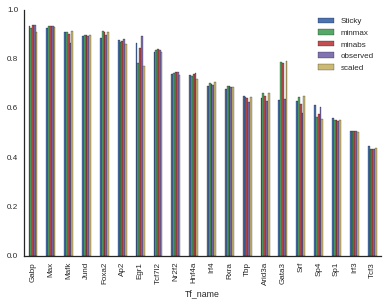

In [21]:
plot_df = pd.DataFrame(columns=["Tf_name", "Sticky", "minmax","minabs", "observed","scaled"])
for tf in combined_list:
    tfs = name2pbmchip[tf]
    energy = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/%s.max_kmer" % (tf.capitalize(), tf.lower())
    #new_test = test.append(pd.read_table(energy, index_col="Motif"))
    new_test = pd.read_table(energy, index_col="Motif")
    new_test.sort_values("AUC", ascending=False, inplace=True)
    # Use this to add each to a specific column fro plotting purpose
    #print tf
    sticky = new_test[new_test.index.str.contains("sticky")]["AUC"].mean()
    minmax = new_test[new_test.index.str.contains("minmax")]["AUC"].mean()
    minabs = new_test[new_test.index.str.contains("minabs")]["AUC"].mean()
    observed = new_test[new_test.index.str.contains("observed")]["AUC"].mean()
    scaled = new_test[new_test.index.str.contains("scaled")]["AUC"].mean()
    
    df2 = pd.DataFrame([[tf, sticky,minmax,minabs,observed,scaled]], columns=["Tf_name","Sticky", "minmax","minabs", "observed","scaled"])
    plot_df = plot_df.append(df2)
    
    #print new_test
plot_df.set_index("Tf_name", inplace=True)
plot_df.sort_values(by="Sticky", ascending=False, inplace=True)
plot_df.plot(kind="bar")
sns.despine()


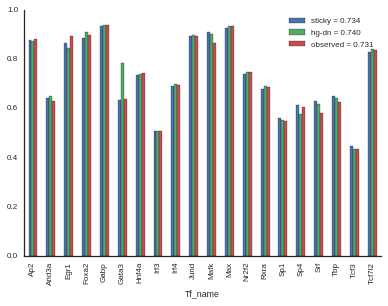

In [22]:
thesis_df = plot_df[["Sticky","minabs","observed"]]

thesis_df.columns = [["sticky","hg-dn","observed"]]
thesis_df = thesis_df.sort_index()
axes = thesis_df.plot.bar()

ave_conserve = thesis_df.mean()
leg = list(thesis_df.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.3f" % (i,ave_conserve[i]))
    
axes.legend(new_leg,loc='best')

axes.set_ylabel("")
sns.despine()

fig = axes.get_figure()
fig.savefig("%s/background_correction.pdf" % figure_path, bbox_inches='tight')